In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import holidays
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import metrics as met 
from sklearn import preprocessing as pre
import warnings
warnings.filterwarnings("ignore")

In [2]:
clicks = pd.read_csv('C:\\Users\\murat.demiralay\\Downloads\\clicks.csv')
clicks['date_ymd'] = pd.to_datetime(clicks['date_ymd'], format='%Y%m%d')
clicks.set_index('date_ymd',inplace = True)
clicks.index.freq = 'D'
print(clicks.shape)
clicks.head()

(242, 1)


,click_count
date_ymd,
2019-01-01,19712
2019-01-02,22632
2019-01-03,22579
2019-01-04,20716
2019-01-05,21953


In [3]:
clicks.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-24',
               '2019-08-25', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='date_ymd', length=242, freq='D')

### Checkin missing dates 

In [4]:
pd.date_range(start = '20190101', end = '20190830' ).difference(clicks.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

No missing date found in the series

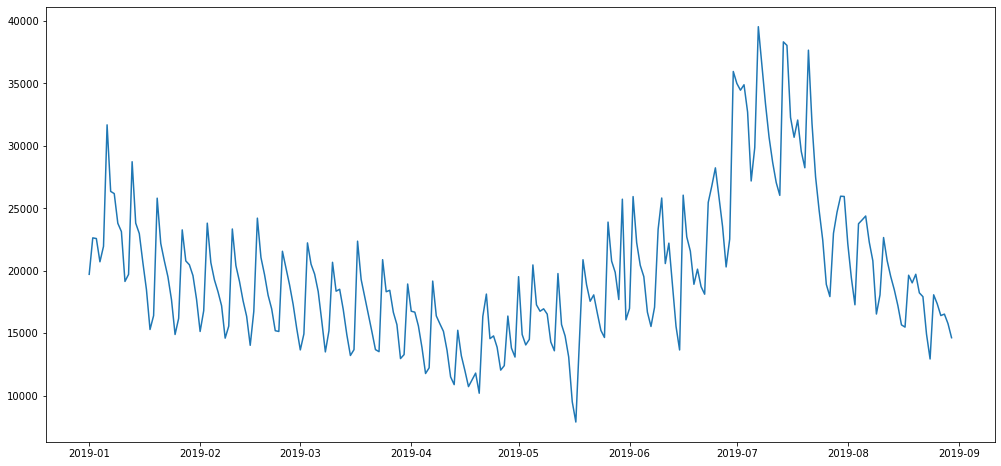

In [5]:
# Lets plot to see how it looks in generall

plt.subplots(figsize=(17,8))
plt.plot(clicks['click_count'])
plt.show()

Time series seems to be cyclic and from an decreasing trend to increasing trend then again decreasing trend. And it does not seems to be statinary.

### Seasonal Decomposition 

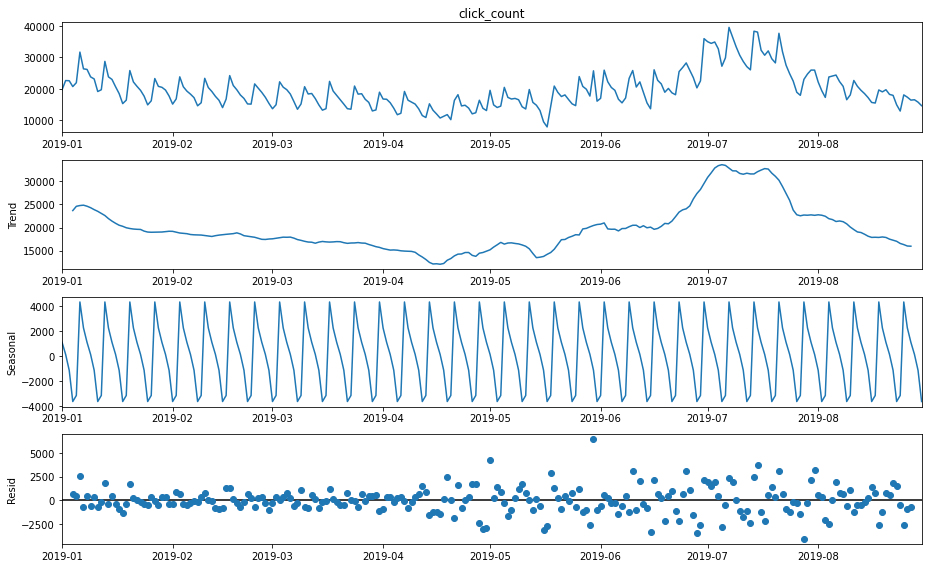

In [6]:
plt.rcParams["figure.figsize"] = (13,8)
result = tsa.seasonal.seasonal_decompose(clicks['click_count'], model='add')
result.plot();

We have a pretty clear cyclic data and it does not seems to be stationary


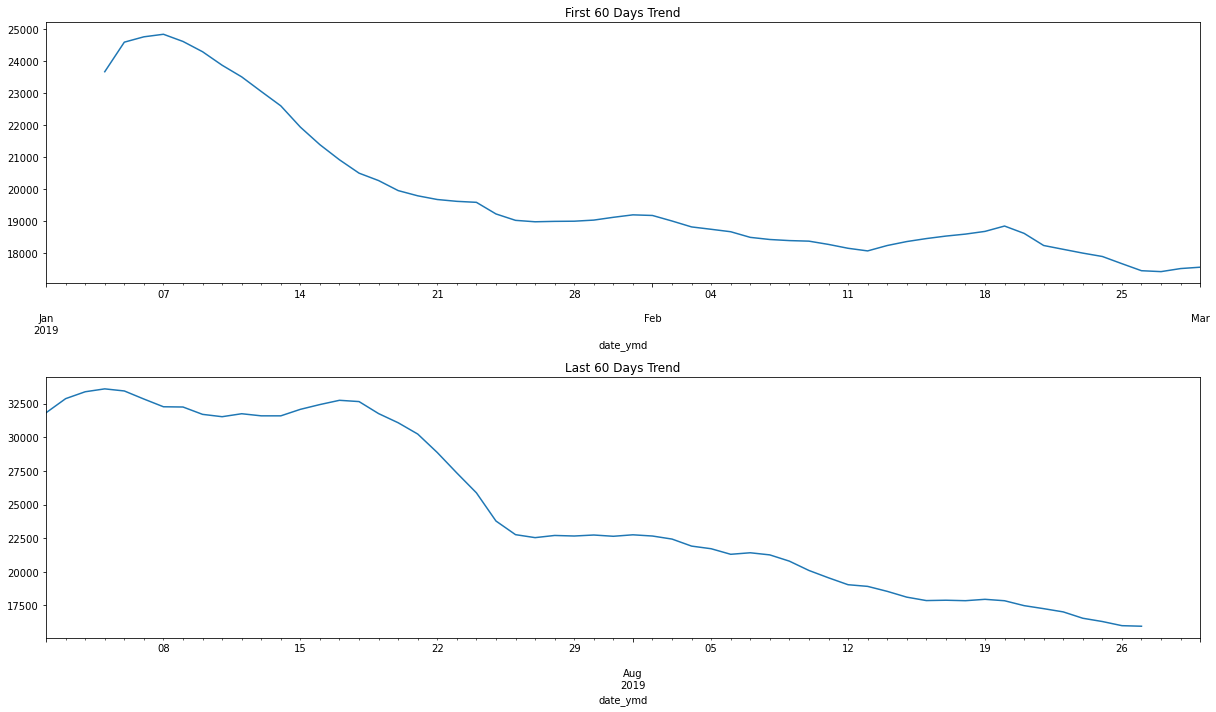

In [7]:
## Lets check first and last 60 days closer

fig, axes = plt.subplots(2,1,figsize=(17,10))
plt.subplot(2,1, 1)
result.trend[:60].plot()
plt.title('First 60 Days Trend')
plt.subplot(2,1, 2)
result.trend[-60:].plot()
plt.title("Last 60 Days Trend")
plt.tight_layout()
plt.show()

First and last 60 days seems to behave similar, and noticing there is 6 months between them.

### Checking possible Outliers

In [8]:
Q1 = np.percentile(clicks['click_count'], 25) 
Q3 = np.percentile(clicks['click_count'], 75) 
IQR = Q3 - Q1 
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print('lower :',lower , 'upper :', upper)
print('Possible Number of Outliers For harcama Column'
      ,clicks[(clicks['click_count']<lower) | (clicks['click_count']  > upper)]['click_count'].count())

lower : 5141.375 upper : 32940.375
Possible Number of Outliers For harcama Column 10


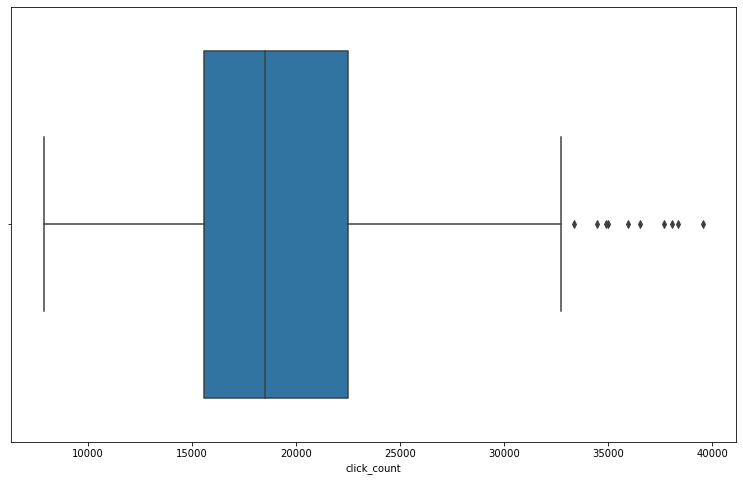

In [9]:
sns.boxplot(clicks.click_count);

In [10]:
clicks[(clicks.click_count > upper) | (clicks.click_count < lower)]

,click_count
date_ymd,
2019-06-30,35962
2019-07-01,35003
2019-07-02,34461
2019-07-03,34899
2019-07-07,39550
2019-07-08,36507
2019-07-09,33372
2019-07-14,38333
2019-07-15,38050


These 10 values might be outliers but they are not that big and many, I will leave them as they are for now.

### Stationarity check

In [11]:
result = tsa.stattools.adfuller(clicks.click_count)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.070676
p-value: 0.256468
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


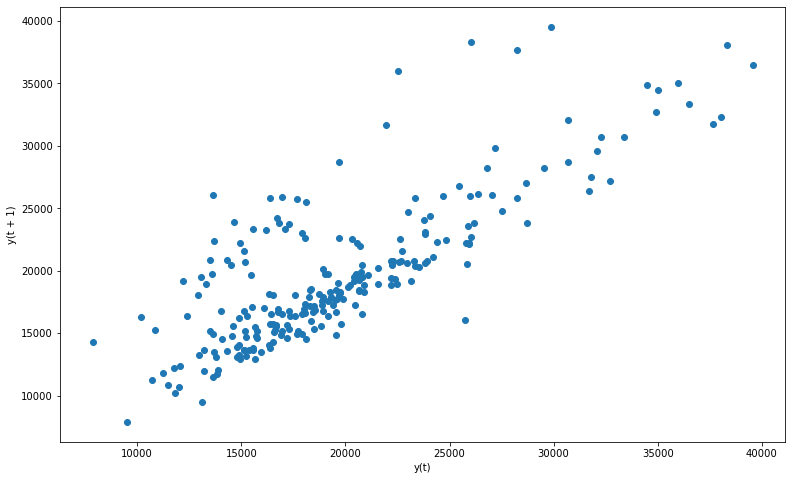

In [12]:
pd.plotting.lag_plot(clicks['click_count']);

p value is above 0.05 and ADF stats is also bigger then critical values therefore, as we saw from plots data is not stationary. Lets try to make it

### Differencing The Time Series

In [13]:
clicks['diff_1'] = tsa.statespace.tools.diff(clicks['click_count'],seasonal_periods=1)
first_value = clicks['click_count'][0]
clicks.dropna(inplace = True)
clicks.head()

,click_count,diff_1
date_ymd,,
2019-01-02,22632,2920.0
2019-01-03,22579,-53.0
2019-01-04,20716,-1863.0
2019-01-05,21953,1237.0
2019-01-06,31686,9733.0


In [14]:
## Lets run ad-fuller test again on differentiated values to see if it became stationary

result = tsa.stattools.adfuller(clicks.diff_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.599992
p-value: 0.005761
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


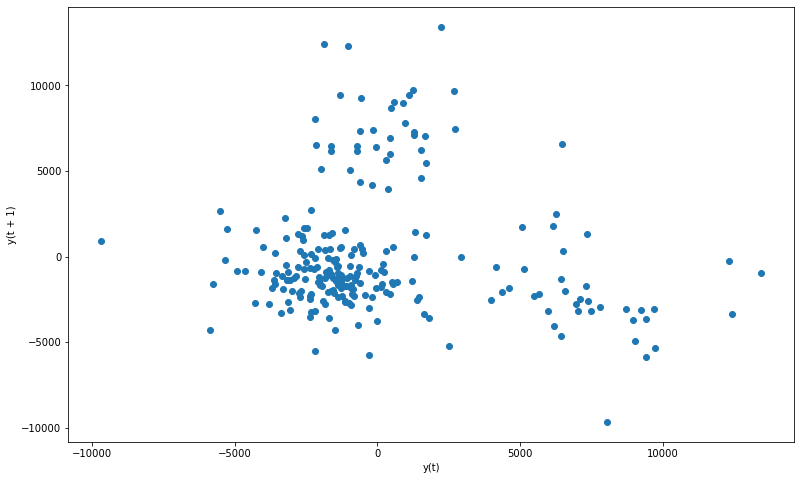

In [15]:
pd.plotting.lag_plot(clicks['diff_1']);

Time series seems to became stationary with taking season = 7 diffence

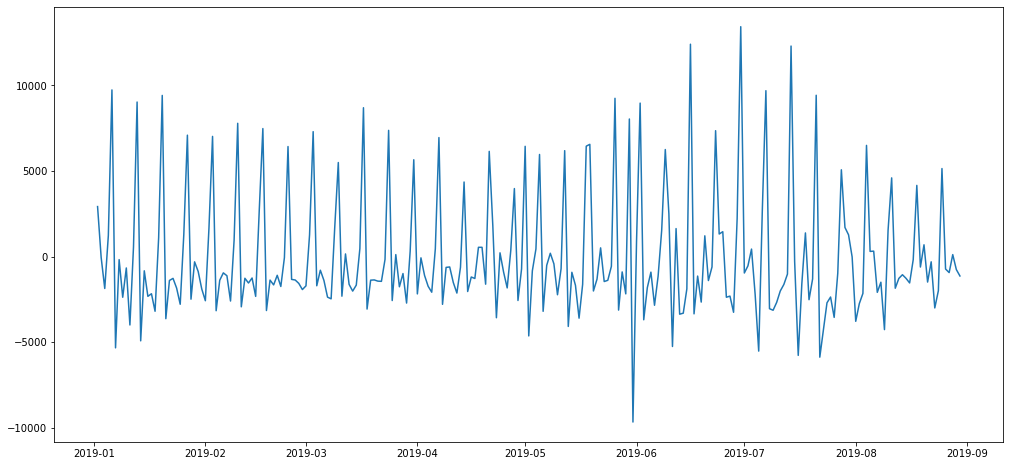

In [16]:
plt.subplots(figsize=(17,8))
plt.plot(clicks['diff_1'])
plt.show()

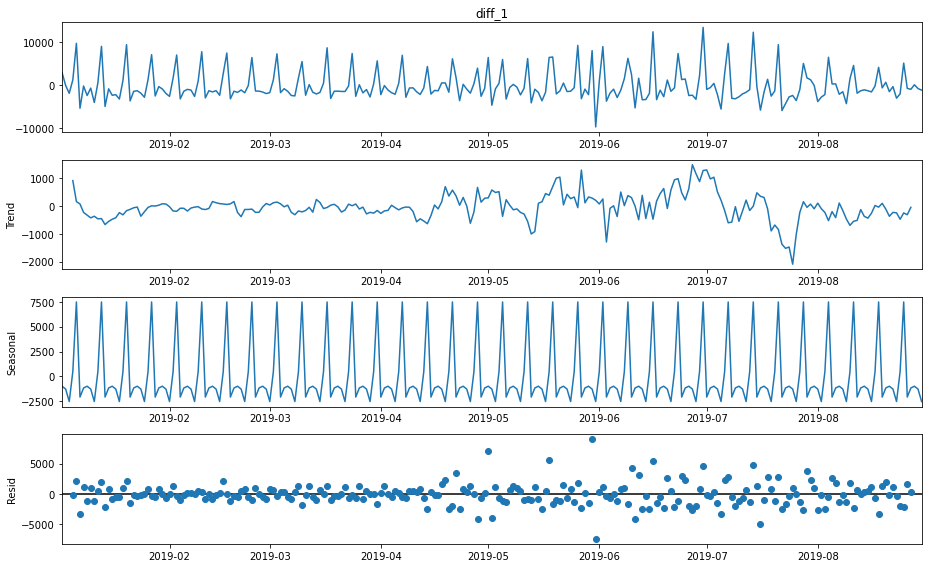

In [17]:
plt.rcParams["figure.figsize"] = (13,8)
result = tsa.seasonal.seasonal_decompose(clicks['diff_1'], model='add')
result.plot();

Eyeballing correlation between lags 

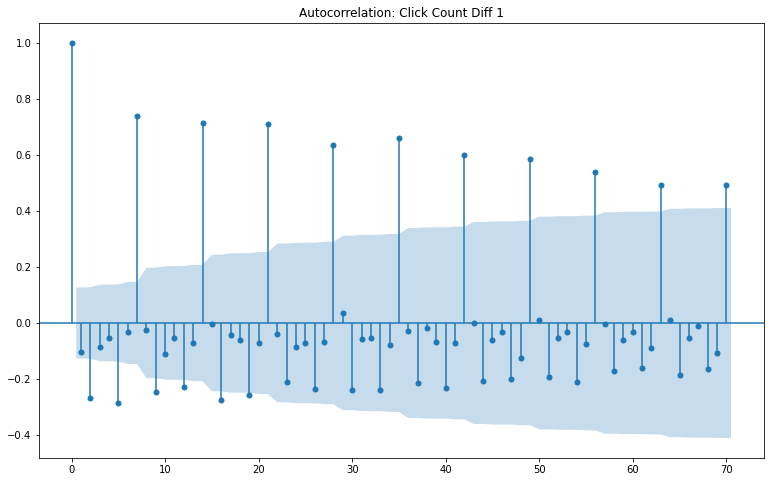

In [19]:
title = 'Autocorrelation: Click Count Diff 1'
lags = 70
plot_acf(clicks['diff_1'],title=title,lags=lags);

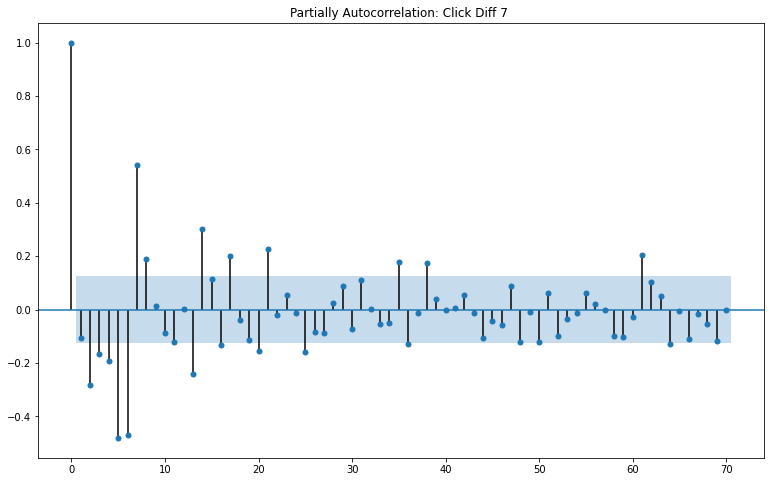

In [19]:
title = 'Partially Autocorrelation: Click Diff 1 '
lags = 70
plot_pacf(clicks['diff_1'],title=title,lags=lags);

Since both plot shows a decay after first lag, AR and MA would be used for better fitting time series. p and q might be 1 but I will use auto arima in order to get precise number. Apart from that we can see that seasonal component will be 7.